In [1]:
def concatify(grammar):
    result = []
    for _, rhs in grammar:
        result.extend([*(rhs + ('#', ))])
    return tuple(result)


In [2]:
def subseqs(seq):
    occurrences = {}
    for i in range(2, len(seq)+1): # window size
        for j in range(0, len(seq) - i + 1):
            s = seq[j:j+i]
            if s not in occurrences:
                occurrences[s] = [j]
            else:
                if j > (occurrences[s][-1] + len(s) - 1):
                    occurrences[s].append(j)
    return occurrences

In [3]:
seq = 'aaaa'
# seq = '0123456789ABCDEF&'
for seq, occs in subseqs(seq).items():
    print(seq, len(occs))

aa 2
aaa 1
aaaa 1


In [23]:
from sequitur import sequitur
from irr import repair, mostCompressive, longestFirst
from lzw import lz78
from grammar import stringifyGrammar, convertGrammarToAnnotation

In [24]:
algorithms = [lz78, repair, mostCompressive, longestFirst, sequitur]

In [25]:
seq = 'abcdabgeabceabcd'
# seq = 'abababababababab'

for a in algorithms:
    g = a(seq)
    print(stringifyGrammar(g))
    print(convertGrammarToAnnotation(g))
    print(concatify(g))
    print(a.__name__, len(concatify(g)) / len(seq))


@0 -> @1,@2,@3,@4,@5,@6,@7,@8,@9,@10,@4
@1 -> a
@2 -> b
@3 -> c
@4 -> d
@5 -> @1,b
@6 -> g
@7 -> e
@8 -> @5,c
@9 -> @7,a
@10 -> @2,c
[((0, 1), (4, 5), (8, 9), (12, 13)), ((1, 2), (5, 6), (9, 10), (13, 14)), ((2, 3), (10, 11), (14, 15)), ((3, 4), (15, 16)), ((0, 2), (4, 6), (8, 10), (12, 14)), ((6, 7),), ((7, 8), (11, 12)), ((0, 3), (8, 11), (12, 15)), ((7, 9), (11, 13)), ((1, 3), (9, 11), (13, 15))]
(1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 4, '#', 'a', '#', 'b', '#', 'c', '#', 'd', '#', 1, 'b', '#', 'g', '#', 'e', '#', 5, 'c', '#', 7, 'a', '#', 2, 'c', '#')
lz78 2.25
@0 -> @2,d,@1,g,e,@2,e,@2,d
@1 -> a,b
@2 -> @1,c
[((0, 2), (4, 6), (8, 10), (12, 14)), ((0, 3), (8, 11), (12, 15))]
(2, 'd', 1, 'g', 'e', 2, 'e', 2, 'd', '#', 'a', 'b', '#', 1, 'c', '#')
repair 1.0
@0 -> @1,d,a,b,g,e,@1,e,@1,d
@1 -> a,b,c
[((0, 3), (8, 11), (12, 15))]
(1, 'd', 'a', 'b', 'g', 'e', 1, 'e', 1, 'd', '#', 'a', 'b', 'c', '#')
mostCompressive 0.9375
@0 -> @1,a,b,g,e,@2,e,@1
@1 -> @2,d
@2 -> a,b,c
[((0, 4), (12, 16)), ((0,

In [ ]:
# seq = 'abcdabgeabceabcd'
seq = 'abababababababab'

for a in algorithms:
    g = a(seq)
    print(stringifyGrammar(g))
    print(concatify(g))
    print(a.__name__, len(concatify(g)) / len(seq))

In [10]:
def greedyIntersection(matchFn, threshold, P, Q):
    '''Compute the intersection of two sets P and Q. Element equality is determined
    using a score function and a threshold.'''
    pMatched = [0]*len(P)
    qMatched = [0]*len(Q)

    for i, p in enumerate(P):
        for j, q in enumerate(Q):
            score = matchFn(p, q)
            if score >= threshold:
                pMatched[i] = 1
                qMatched[j] = 1

    return sum(pMatched), sum(qMatched)

def generalScore(matchFn, P, Q):
    allScores = []
    for i, p in enumerate(P):
        for j, q in enumerate(Q):
            score = matchFn(p, q)
            allScores.append(score)

    return sum(allScores) / len(allScores)

from main import compareLevenshteinStrict

def cmpFn(P, Q, threshold):
    return greedyIntersection(compareLevenshteinStrict, threshold, P, Q)

def gScoreFn(P, Q):
    return generalScore(compareLevenshteinStrict, P, Q)

In [8]:
from common import gzPickleIter
from viewpoint import createViewpointFn, duration, midi
from grammar import convertGrammarToAnnotation

In [48]:

viewpointFn = createViewpointFn([duration])
# data = gzPickleIter('../datasets/hymns/hymns.pkl.gz')
data = gzPickleIter('../datasets/essen/essen1000.pkl.gz')
threshold = 0.7

ratios = []
f1s = []
for d in data:
    seq, gt, datasetName, index = d
    vpSeq = tuple(viewpointFn(seq))
    grammar = longestFirst(vpSeq)
    discovered = convertGrammarToAnnotation(grammar)
    P = [tuple(vpSeq[s:e] for s, e in p) for p in gt]
    Q = [tuple(vpSeq[s:e] for s, e in p) for p in discovered]
    if len(Q) == 0:
        precision, recall = 0.0, 0.0
        F1 = 0.0
    else:
        pMatched, qMatched = cmpFn(P, Q, threshold)
        precision = qMatched / len(Q)
        recall = pMatched / len(P)
        if precision + recall == 0:
            F1 = 0.0
        else:
            F1 = (2 * precision * recall) / (precision + recall)
    ratios.append(len(concatify(grammar)) / len(seq))
    f1s.append(F1)


    

0.24275368377969775


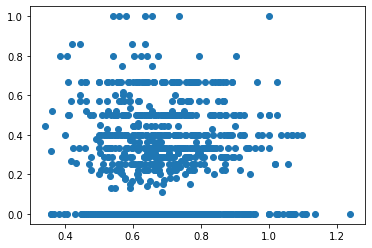

In [50]:

import matplotlib.pyplot as plt
fig, ax = plt.subplots()
ax.scatter(ratios, f1s)
print(sum(f1s) /len(f1s))

In [21]:
viewpointFn = createViewpointFn([duration])
data = gzPickleIter('../datasets/hymns/hymns.pkl.gz')
# data = gzPickleIter('../datasets/essen/essen1000.pkl.gz')
# data = gzPickleIter('../datasets/jku/jku.pkl.gz')

viewpointFn = createViewpointFn([duration])

scores = []
compRatios = []
for i, d in enumerate(data):
    seq, gt, datasetName, index = d
    vpSeq = tuple(viewpointFn(seq))
    for j, alg in enumerate([mostCompressive]):
        # print(i, j)
        grammar = alg(vpSeq)
        cc = concatify(grammar)
        discovered = convertGrammarToAnnotation(grammar)
        P = [tuple(vpSeq[s:e] for s, e in p) for p in gt]
        Q = [tuple(vpSeq[s:e] for s, e in p) for p in discovered]
        if len(Q) == 0:
            print('Q zero')
            raise
        score = gScoreFn(P, Q)
        ratio = len(cc) / len(seq)
        scores.append(score)
        compRatios.append(ratio)

Text(0.5, 0, 'Compression Ratio')

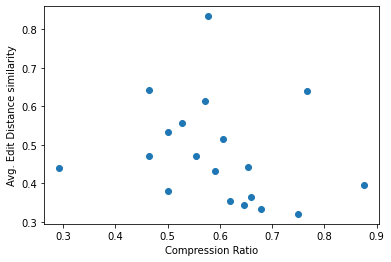

In [22]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots()
ax.scatter(compRatios, scores)
ax.set_ylabel('Avg. Edit Distance similarity')
ax.set_xlabel('Compression Ratio')
# ax.plot()


In [53]:
def mean(iter):
    return sum(iter) / len(iter)

for alg, res in results.items():
    print(alg, mean(res))

lzw 1.5770768572115426
repair 0.6905222476904915
mostCompressive 0.611797613439662
longestFirst 0.6899867049295226
sequitur 0.6255803381477434


In [3]:
from lzw import lz78
from grammar import stringifyGrammar

seq = tuple('aabbababaab')
result = lz78(seq)
print(stringifyGrammar(result))

@0 -> @1,@2,@3,@4,@5,@2
@1 -> a
@2 -> @1,b
@3 -> b
@4 -> @2,a
@5 -> @3,a


In [ ]:
from main import greedyIntersection, compareLevenshteinStrict
from lzw import l
